First we import the necessary code

In [2]:
import torch
import torch.nn as nn
from src.transformer import DecoderTransformer
from src.data import random_values, create_signals, sine
from src.train_eval import make_prediction
from src.train_eval import predict_next_values
from src.graph import plot_prediction
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_SEQUENCE_LENGTH = 512
TIME_STEP = 0.5 / MAX_SEQUENCE_LENGTH
MIN_OMEGA = 85
MAX_OMEGA = 115

best_model = DecoderTransformer(
    output_parameter_count=1,
    d_model=128,
    num_heads=16,
    num_layers=2,
    d_ff=512,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dropout=0.1
).to(device)

best_model.load_state_dict(torch.load("models/signal_prediction_triple.pt", map_location=device))

<All keys matched successfully>

In [4]:
EVAL_COUNT = 256

frequencies_1 = random_values(EVAL_COUNT, MIN_OMEGA, MAX_OMEGA)
frequencies_2 = random_values(EVAL_COUNT, MIN_OMEGA, MAX_OMEGA)
frequencies_3 = random_values(EVAL_COUNT, MIN_OMEGA, MAX_OMEGA)
phases_1 = random_values(EVAL_COUNT, 0, 2 * torch.pi)
phases_2 = random_values(EVAL_COUNT, 0, 2 * torch.pi)
phases_3 = random_values(EVAL_COUNT, 0, 2 * torch.pi)
            
sine_1 = create_signals(
    omegas=frequencies_1,
    signal_function=sine,
    length=MAX_SEQUENCE_LENGTH * 2,
    time_step=TIME_STEP,
    phases=phases_1
)
        
sine_2 = create_signals(
    omegas=frequencies_2,
    signal_function=sine,
    length=MAX_SEQUENCE_LENGTH * 2,
    time_step=TIME_STEP,
    phases=phases_2
)

sine_3 = create_signals(
    omegas=frequencies_3,
    signal_function=sine,
    length=MAX_SEQUENCE_LENGTH * 2,
    time_step=TIME_STEP,
    phases=phases_3
)
    
signals = (sine_1 + sine_2 + sine_3) / 3
values, next_values = signals.split((MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH), dim=1)
next_value = next_values[:, 0]

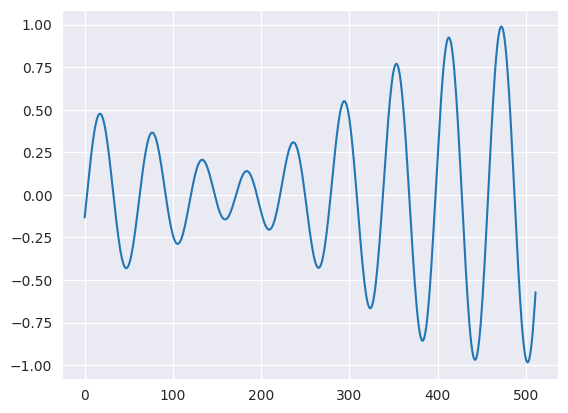

In [9]:
plt.plot(values[0])
plt.show()

Evaluation MAE: 0.009999


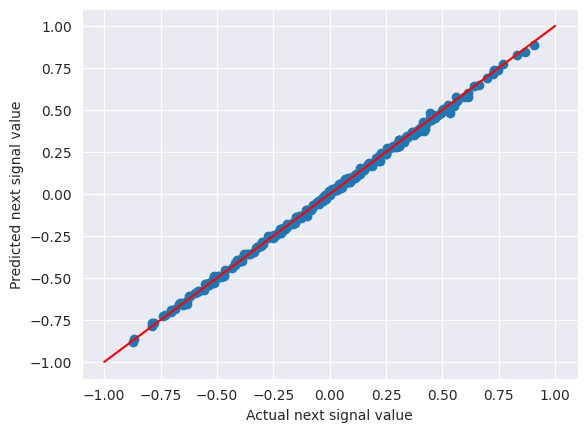

In [26]:
prediction = make_prediction(best_model, values, batch_size=16)
plt.scatter(next_value, prediction)
plt.plot([-1, 1], [-1, 1], "r")
plt.xlabel("Actual next signal value")
plt.ylabel("Predicted next signal value")
loss = nn.L1Loss()(next_value.flatten(), prediction).item()
print(f"Evaluation MAE: {loss:.6f}")

In [10]:
index = 0
_, predicted_values = predict_next_values(best_model, values[index], MAX_SEQUENCE_LENGTH, count=MAX_SEQUENCE_LENGTH)

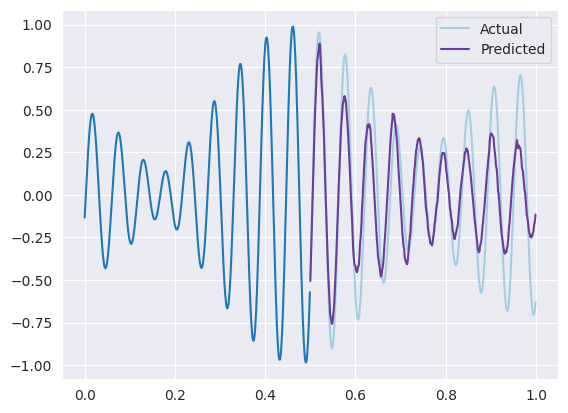

In [11]:
fig = plot_prediction(values[index], next_values[index], predicted_values, TIME_STEP)